In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pickle

# Nova seção

In [2]:
from random import sample
import random

from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/diegonogare/GoogleColab/main/Telescope%20data.csv')

np.random.seed(42)

In [6]:
print(df['Class'])

0        g
1        g
2        g
3        g
4        g
        ..
19015    h
19016    h
19017    h
19018    h
19019    h
Name: Class, Length: 19020, dtype: object


In [7]:
#one_hot_class = pd.get_dummies(df['Class'])
#df = df.join(one_hot_class)

df['Class_num'] = np.where(df['Class'] == 'g', 1.0, 0.0)

In [8]:
print('Dataset original')
print('Hadron = ' + str(len(df[df['Class'] == 'h'])) )
print('Gamma = ' + str(len(df[df['Class'] == 'g'])) )

#print('Dataset com One Hot Encoding')
#print('Hadron_onehot = ' + str(len(df[df['h'] == 1])) )
#print('Gamma_onehot = ' + str(len(df[df['g'] == 1])) )

print('Dataset com Class numerica')
print('Hadron_num = ' + str(len(df[df['Class_num'] == 0])) )
print('Gamma_num = ' + str(len(df[df['Class_num'] == 1])) )


Dataset original
Hadron = 6688
Gamma = 12332
Dataset com Class numerica
Hadron_num = 6688
Gamma_num = 12332


In [9]:
df = df.drop(['Class'],axis=1)

In [10]:
# Explore the data set
col_names = df.columns.tolist()
df.shape
df.describe

<bound method NDFrame.describe of         fLength    fWidth   fSize  ...   fAlpha     fDist  Class_num
0       28.7967   16.0021  2.6449  ...  40.0920   81.8828        1.0
1       31.6036   11.7235  2.5185  ...   6.3609  205.2610        1.0
2      162.0520  136.0310  4.0612  ...  76.9600  256.7880        1.0
3       23.8172    9.5728  2.3385  ...  10.4490  116.7370        1.0
4       75.1362   30.9205  3.1611  ...   4.6480  356.4620        1.0
...         ...       ...     ...  ...      ...       ...        ...
19015   21.3846   10.9170  2.6161  ...   2.4229  106.8258        0.0
19016   28.9452    6.7020  2.2672  ...  86.7975  247.4560        0.0
19017   75.4455   47.5305  3.4483  ...  30.2987  256.5166        0.0
19018  120.5135   76.9018  3.9939  ...  84.6874  408.3166        0.0
19019  187.1814   53.0014  3.2093  ...  52.7310  272.3174        0.0

[19020 rows x 11 columns]>

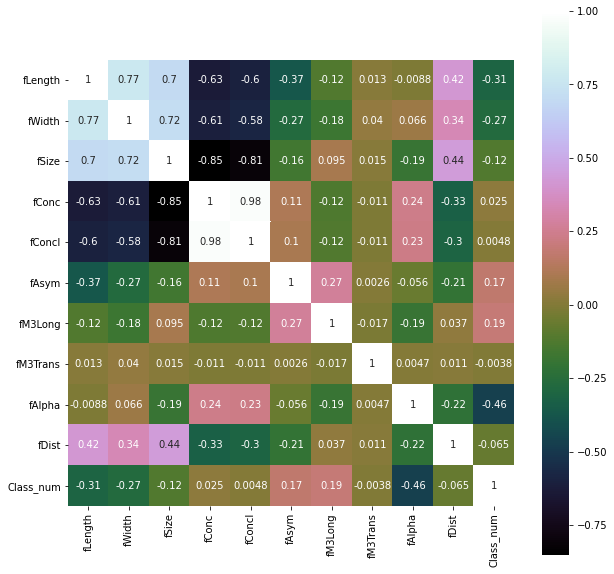

In [11]:
# Correlation heatmap
correlation = df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')


In [ ]:
# Pairwise plots (take a 5% sample as CPU intensive)
#df_sample = df.sample(frac=0.05)
#pplot = sns.pairplot(df_sample, hue="Class");


In [12]:
# Split data into train, test and validate
# 80% - train set, 20% - validation set
train, test = np.split( df.sample(frac=1), [int(.8*len(df))])

print(train.shape, test.shape)

# Separate target and predictors
y_train = train['Class_num']
x_train = train.drop(['Class_num'], axis=1)
y_test = test['Class_num']
x_test = test.drop(['Class_num'], axis=1)


(15216, 11) (3804, 11)


In [13]:
# Create variable lists and drop
all_vars = x_train.columns.tolist()
top_5_vars = ['fAlpha', 'fLength', 'fWidth', 'fSize', 'fM3Long']
bottom_vars = [cols for cols in all_vars if cols not in top_5_vars]

# Drop less important variables leaving the top_5
x_train    = x_train.drop(bottom_vars, axis=1)
x_test     = x_test.drop(bottom_vars, axis=1)


In [14]:
# Instantiate with a max depth of 3
tree_model = tree.DecisionTreeClassifier(max_depth=3)
# Fit a decision tree
tree_model = tree_model.fit(x_train, y_train)
# Training accuracy
tree_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(tree_model.predict(x_test))
probs = pd.DataFrame(tree_model.predict_proba(x_test))

# Store metrics
tree_accuracy = metrics.accuracy_score(y_test, predicted)
tree_roc_auc = metrics.roc_auc_score(y_test, probs[1])
tree_confus_matrix = metrics.confusion_matrix(y_test, predicted)
tree_classification_report = metrics.classification_report(y_test, predicted)
tree_precision = metrics.precision_score(y_test, predicted, pos_label=1)
tree_recall = metrics.recall_score(y_test, predicted, pos_label=1)
tree_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [15]:
predicted

,0
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
3799,1.0
3800,1.0
3801,1.0
3802,0.0


In [16]:
probs

,0,1
0,0.092008,0.907992
1,0.779661,0.220339
2,0.293103,0.706897
3,0.092008,0.907992
4,0.092008,0.907992
...,...,...
3799,0.092008,0.907992
3800,0.092008,0.907992
3801,0.277337,0.722663
3802,0.551746,0.448254


In [17]:
tree_roc_auc

0.8205697414875548

In [18]:
# Evaluate the model using 10-fold cross-validation
tree_cv_scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=3),
                                x_test, y_test, scoring='precision', cv=10)

tree_cv_mean = np.mean(tree_cv_scores)

# Output decision plot
dot_data = tree.export_graphviz(tree_model, out_file=None,
                     feature_names=x_test.columns.tolist(),
                     class_names=['g', 'h'],
                     filled=True, rounded=True,
                     special_characters=True)
#print(dot_data)

graph = graph_from_dot_data(dot_data)
graph.write_png("CTA_DT.png")

True

In [19]:
# EVALUATE
models = pd.DataFrame({
    'Modelo'    : ['Decision Tree'],
    'Acurácia' : [tree_accuracy],
    'Precisão': [tree_precision],
    'Recall'   : [tree_recall],
    'F1'       : [tree_f1],
    'AUC (Curva ROC)' : [tree_roc_auc]
    })

# Create x and y from all data
#y = df['Class_num']
#x = df.drop(['Class_num'], axis=1)


In [20]:
models
#print(tree_confus_matrix)

,Modelo,Acurácia,Precisão,Recall,F1,AUC (Curva ROC)
0,Decision Tree,0.794427,0.813264,0.887586,0.848801,0.82057


In [22]:
# Save model
with open('CTA_DT.pkl', 'wb') as DT_Telescopio:
    pickle.dump(tree_model, DT_Telescopio)

In [23]:
#umaLinha = pd.DataFrame({
#    'fLength':[19.2512],
#    'fWidth':[14.7951],
#    'fSize':[2.2954],
#    'fM3Long':[8.9581],
#    'fAlpha':[51.6492]  
#})


linhaAleatoria = int(random.random()*len(df))
df.iloc[linhaAleatoria]

#print(df.head(1))
#print(umaLinha)

fLength       13.0679
fWidth        10.7972
fSize          2.1287
fConc          0.7658
fConcl         0.4647
fAsym         13.7665
fM3Long       -4.3048
fM3Trans      10.1883
fAlpha        84.7088
fDist        273.6620
Class_num      1.0000
Name: 9008, dtype: float64